# USGS IRIS Crossref
AUTH: Nathan T. Stevens  
ORG: Pacific Northwest Seismic Network  
LICENSE: GNU GPLv3  
PURPOSE: This script pull seismic station data from the IRIS-DMC and cross references it with USGS stream gage site location
data queried by the `USGS_Stream_Gage_Site_Metadata_Downloader.ipynb` notebook and forms closest seismic-gage pairs with distances
and azimuths as an outpu CSV.

In [24]:
# Import dependencies
import os
import numpy as np
import pandas as pd
from pathlib import Path
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from obspy.geodetics import gps2dist_azimuth

In [25]:
# Connect to IRIS DMC
client = Client('IRIS')
# Create absolute path to data directory
DATADIR = Path().cwd()/'USGS_Stream_Gage'
# Load gage site locations
df_gage = pd.read_csv(DATADIR/'usgs_gage_site_metadata.csv', index_col='id')
display(df_gage)

,name,lat,lng,class,url,huc_cd,% normal(mean) (%),Status,% normal(median) (%),Length of record (years),Stage (ft),Discharge (cfs),Stage (adj) (ft),Class,Date
id,,,,,,,,,,,,,,,
10352500,"USGS 10352500 MCDERMITT CK NR MCDERMITT, NV",41.966557,-117.831812,4,https://waterdata.usgs.gov/monitoring-location...,1.604020e+07,28.54,NaN,49.93,74.0,2.23,3.77,4547.23,10-24,2025-12-15 12:00:00-08:00
10387110,USGS 10387110 CHEWAUCAN RIVER AT MOUTH NEAR VA...,42.522081,-120.249450,0,https://waterdata.usgs.gov/monitoring-location...,1.712001e+11,NaN,NaN,NaN,NaN,8.52,NaN,NaN,Not-ranked,2025-12-15 12:00:00-08:00
10387150,"USGS 10387150 LAKE ABERT NEAR VALLEY FALLS, OR",42.603500,-120.187306,0,https://waterdata.usgs.gov/monitoring-location...,1.712001e+07,NaN,NaN,NaN,NaN,4253.30,NaN,4253.30,Not-ranked,2025-12-15 12:45:00-08:00
10396000,USGS 10396000 DONNER UND BLITZEN RIVER NR FREN...,42.790833,-118.867500,5,https://waterdata.usgs.gov/monitoring-location...,1.712000e+07,90.19,NaN,120.24,94.0,1.99,50.50,4262.32,25-75,2025-12-15 12:00:00-08:00
11491450,"USGS 11491450 IRVING CREEK NEAR LENZ, OR",42.951667,-121.459056,0,https://waterdata.usgs.gov/monitoring-location...,1.801020e+07,NaN,NaN,NaN,NaN,19.71,0.92,4636.71,Not-ranked,2025-12-15 12:30:00-08:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14244180,USGS 14244180 COWLITZ RIVER NEAR 1ST AVE NW AT...,46.147220,-122.916055,0,https://waterdata.usgs.gov/monitoring-location...,NaN,NaN,NaN,NaN,NaN,10.79,NaN,10.79,Not-ranked,2025-09-08 12:15:00-07:00
14246900,"USGS 14246900 COLUMBIA RIVER AT PORT WESTWARD,...",46.181221,-123.183454,5,https://waterdata.usgs.gov/monitoring-location...,1.708000e+07,82.78,NaN,92.14,34.0,8.24,211000.00,7.24,25-75,2025-12-15 12:40:00-08:00
14246900,"USGS 14246900 COLUMBIA RIVER AT PORT WESTWARD,...",46.181221,-123.183454,5,https://waterdata.usgs.gov/monitoring-location...,1.708000e+07,82.78,NaN,92.14,34.0,8.24,211000.00,7.24,25-75,2025-12-15 12:40:00-08:00


In [26]:
# Get station query kwargs
staqkwargs = {
    'channel': 'EHZ,HHZ,ENZ,HNZ,BNZ',
    'minlatitude': df_gage.lat.min(),
    'minlongitude': df_gage.lng.min(),
    'maxlongitude': df_gage.lng.max(),
    'maxlatitude': df_gage.lat.max(),
    'starttime': UTCDateTime('2025-01-01'),
    'endtime': UTCDateTime('2025-12-31'),
    'level': 'station'
}

display(staqkwargs)

# Query stations
inv = client.get_stations(**staqkwargs)




{'channel': 'EHZ,HHZ,ENZ,HNZ,BNZ',
 'minlatitude': 41.92788026,
 'minlongitude': -124.6257923,
 'maxlongitude': -116.9146429,
 'maxlatitude': 49.00074966,
 'starttime': 2025-01-01T00:00:00.000000Z,
 'endtime': 2025-12-31T00:00:00.000000Z,
 'level': 'station'}

In [27]:
# Convert seismic sites into dataframe
nsll_set = set()
for net in inv.networks:
    for sta in net.stations:
        lat = sta.latitude
        lon = sta.longitude
        tup = (net.code, sta.code, lat, lon)
        nsll_set.add(tup) 

df_seis = pd.DataFrame(list(nsll_set), columns=['network','station','latitude','longitude'])
display(df_seis)

,network,station,latitude,longitude
0,UO,LOGZ,44.775680,-123.672900
1,GS,LAU,47.664001,-122.363800
2,NP,7041,48.115170,-123.436680
3,UO,WYLD,43.144475,-123.429208
4,RE,SCGN,45.470749,-123.201868
...,...,...,...,...
882,UW,HANS,47.907360,-122.569410
883,GS,SOC3,47.561001,-122.338203
884,UO,COQI,43.187570,-124.183530
885,UO,ROCKA,45.606495,-123.934609


In [32]:
# Run cross reference
holder = []
for usgs_id, row in df_gage.iterrows():
    lat_g = row.lat
    lon_g = row.lng
    dlat = abs(df_seis.latitude - lat_g)
    dlon = abs(df_seis.longitude - lon_g)
    dll = dlat + dlon
    seis_nn_idx = np.argmin(dll)
    ser_seis_nn = df_seis.iloc[seis_nn_idx]
    lat_s, lon_s = ser_seis_nn.latitude, ser_seis_nn.longitude
    dist, g2s, s2g = gps2dist_azimuth(lat_g, lon_g, lat_s, lon_s)
    tup = (f'{ser_seis_nn.network}.{ser_seis_nn.station}', lat_s, lon_s, usgs_id, lat_g, lon_g, dist*1e-3, g2s, s2g)
    holder.append(tup)

df_nn = pd.DataFrame(holder, columns=['SEIS_SITE','SEIS_LAT','SEIS_LON','GAGE_SITE','GAGE_LAT','GAGE_LON','DIST_KM','G2S_AZ','S2G_AZ'])
df_nn = df_nn.sort_values('DIST_KM')

display(df_nn)

/var/folders/j_/jdy4xlk97nzgs_c2n4nj4ktw0000gn/T/ipykernel_48223/4066938390.py:12: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  dist, g2s, s2g = gps2dist_azimuth(lat_g, lon_g, lat_s, lon_s)


,SEIS_SITE,SEIS_LAT,SEIS_LON,GAGE_SITE,GAGE_LAT,GAGE_LON,DIST_KM,G2S_AZ,S2G_AZ
214,NP.2108,44.45000,-122.54880,14186100,44.450000,-122.549000,0.015920,89.999930,270.000070
198,NP.2133,44.72220,-122.24990,14180500,44.722061,-122.250058,0.019888,39.094545,219.094656
377,NP.2158,47.38557,-123.60570,12035380,47.385335,-123.605698,0.026083,359.684854,179.684853
162,NP.2137,44.12770,-122.24490,14159400,44.127372,-122.244744,0.038494,341.124277,161.124168
128,NP.2143,43.70990,-122.42130,14145100,43.709575,-122.421111,0.039191,337.127849,157.127718
...,...,...,...,...,...,...,...,...,...
0,US.WVOR,42.43390,-118.63670,10352500,41.966557,-117.831812,84.342877,308.256035,127.715363
34,UW.JORV,42.97768,-117.05332,13213000,43.781667,-116.972778,89.561162,184.206916,4.151596
38,US.BMO,44.85250,-117.30600,13251000,44.042222,-116.925278,95.002017,341.530543,161.263934
37,US.BMO,44.85250,-117.30600,13233300,43.987500,-117.218889,96.369193,355.902299,175.841327


In [33]:
# Save nearest neighbor search to disk
df_nn.to_csv(DATADIR/'gage_seis_nearest_neighbors.csv', header=True, index=False)

In [34]:
%matplotlib
import matplotlib.pyplot as plt

Using matplotlib backend: module://matplotlib_inline.backend_inline


Text(0, 0.5, 'Latitude [$^oE$]')

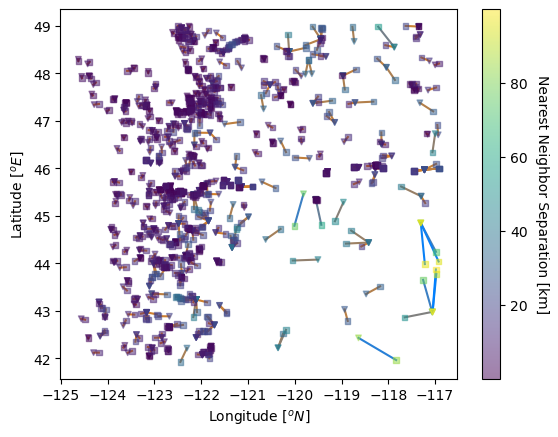

In [44]:
plt.figure()
plt.scatter(df_nn.SEIS_LON, df_nn.SEIS_LAT, c=df_nn.DIST_KM, marker='v', s=16, alpha=0.5, zorder=3)
ch = plt.colorbar()
ch.set_label('Nearest Neighbor Separation [km]', rotation=270, labelpad=15)
plt.scatter(df_nn.GAGE_LON, df_nn.GAGE_LAT, c=df_nn.DIST_KM, marker='s', s=16, alpha=0.5, zorder=3)
for _, row in df_nn.iterrows():
    color = (1 - (row.DIST_KM/df_nn.DIST_KM.max()), 0.5, row.DIST_KM/df_nn.DIST_KM.max())
    plt.plot([row.SEIS_LON, row.GAGE_LON], [row.SEIS_LAT, row.GAGE_LAT], '-', color=color, zorder=1)

plt.xlabel('Longitude [$^oN$]')
plt.ylabel('Latitude [$^oE$]')